In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import multiprocessing as mp
from tqdm.notebook import tqdm
import urllib.request
from numba import njit
import seaborn as sns
from scipy.stats import sem, t
import os
import itertools

In [43]:
random_runs = 50
ant_sizes = [10, 50, 100, 500, 1000]
max_cycles = [10, 50, 100, 500, 1000, 2000]
tau_min = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 3, 4]
tau_max = [2, 3, 5, 8, 13, 21, 34]
alpha = [0.8, 0.9, 1, 1.1, 1.2, 1.5, 2, 3]
evaporation_rate = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.997]

parameters = [ant_sizes, max_cycles, tau_min, tau_max, alpha, evaporation_rate]

In [44]:
def parse_dimacs_to_adjacency_matrix(url):
    # Open the URL and read the lines
    with urllib.request.urlopen(url) as u:
        content = u.read().decode()

    # Split the content into lines
    lines = content.split("\n")
    
    # Filter only the lines that start with 'p' and 'e'
    p_lines = [line for line in lines if line.startswith('p')]
    e_lines = [line for line in lines if line.startswith('e')]

    # Parse the 'p' line to get the number of vertices
    _, _, num_vertices, _ = p_lines[0].split()
    num_vertices = int(num_vertices)

    # Initialize an empty adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices))

    # Parse each 'e' line and fill in the adjacency matrix
    for line in e_lines:
        _, vertex1, vertex2 = line.split()
        vertex1, vertex2 = int(vertex1) - 1, int(vertex2) - 1  # vertices are 1-indexed in the DIMACS format
        adjacency_matrix[vertex1][vertex2] = True
        adjacency_matrix[vertex2][vertex1] = True  # this is because the graph is undirected

    return adjacency_matrix

graph_url = 'http://cedric.cnam.fr/~porumbed/graphs/dsjc125.1.col'
graph_url = 'http://cedric.cnam.fr/~porumbed/graphs/dsjc500.5.col'
adjacency_matrix = parse_dimacs_to_adjacency_matrix(graph_url)

print(adjacency_matrix)


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [45]:

def draw_graph(G, clique=None, title=None):
    # Let's use a circular layout for the vertices
    t = np.linspace(0, 2*np.pi, num=G.shape[0]+1)[:-1]
    x = np.cos(t)
    y = np.sin(t)

    fig, ax = plt.subplots()

    # make the figsize proportional to the number of vertices
    fig.set_size_inches(6*(G.shape[0]/50), 6*(G.shape[0]/50))
    
    # draw vertices
    ax.scatter(x, y)

    # draw edges
    for i in range(G.shape[0]):
        for j in range(i+1, G.shape[0]):
            if G[i, j] == 1:
                ax.plot([x[i], x[j]], [y[i], y[j]], color='gray')

    # highlight clique
    if clique is not None:
        if not isinstance(clique, list):
            clique = list(clique)
        cx = x[clique]
        cy = y[clique]
        ax.scatter(cx, cy, color='red')
        for i in range(len(clique)):
            for j in range(i+1, len(clique)):
                ax.plot([cx[i], cx[j]], [cy[i], cy[j]], color='red')
    
    if title is not None:
        ax.set_title(title)

    plt.show()
    


In [46]:
# create a 20x20 matrix filled with zeros
G = np.zeros((20, 20), dtype=int)
np.random.seed(42)
# create a 4-clique (vertices 0 to 3 form the clique)
G[0:4, 0:4] = 1

# add edges (0, 4), (1, 5), (3, 5) and (2, 4)
random_additions = 20

for i in range(random_additions):
    x = np.random.randint(0, 20)
    y = np.random.randint(0, 20)
    if x == y:
        y = np.random.randint(0, 20)
    G[x, y] = G[y, x] = 1


# connect edges that are disconnected

for i in range(len(G)):
    if np.sum(G[i]) == 0:
        G[i, i+1] = G[i+1, i] = 1

# Verify the graph
G = adjacency_matrix
#print(G)
#draw_graph(G)



In [47]:
def construct_clique_regular(G, tau, n, alpha):
    vi = np.random.randint(n)  # choose a first vertex
    Ck = {vi}  # initialize clique
    Candidates = {vj for vj in range(n) if G[vi, vj]}  # find neighbors

    while Candidates:  # continue while there are candidates
        probs = [tau[vi, vj] for vj in Candidates]  # get pheromone trails
        probs   = np.power(probs, alpha)  # raise to alpha factor
        probs /= np.sum(probs)  # normalize to get probabilities
        vi = np.random.choice(list(Candidates), p=probs)  # choose next vertex

        new_neighbors = {vj for vj in range(n) if G[vi, vj]}  # find new neighbors
        Candidates &= new_neighbors  # update candidates to be the intersection of current candidates and new neighbors

        if all(G[vi][v] for v in Ck):  # if the new vertex is a neighbor of all vertices in the current clique
            Ck.add(vi)  # then add it to the clique

    return Ck

In [48]:
@njit
def seed_numba(seed: int):
    np.random.seed(seed)

def seed(seed: int):
    np.random.seed(seed)
    seed_numba(seed)

In [49]:
@njit
def choice_with_weights(probs):
    cumulative_probs = np.cumsum(probs)
    random_sample = np.random.rand()
    for i in range(len(probs)):
        if random_sample < cumulative_probs[i]:
            return i
    return len(probs) - 1

@njit
def construct_clique(G, tau, n, alpha):
    vi = np.random.randint(n)  # choose a first vertex
    Ck = np.zeros(n, dtype=np.bool_)  # initialize clique
    Ck[vi] = True

    Candidates = np.zeros(n, dtype=np.bool_)  # initialize candidates
    for vj in range(n):
        if G[vi, vj]:
            Candidates[vj] = True

    while np.any(Candidates):  # continue while there are candidates
        # get pheromone trails
        probs = np.zeros(n) 
        for vj in range(n):
            if Candidates[vj]:
                probs[vj] = np.power(tau[vi][vj], alpha)
        # normalize to get probabilities
        total = np.sum(probs)
        probs = probs / total if total > 0 else probs

        # choose next vertex
        vi = choice_with_weights(probs)
        # find new neighbors
        new_neighbors = np.zeros(n, dtype=np.bool_)
        for vj in range(n):
            if G[vi][vj]:
                new_neighbors[vj] = True

        # update candidates to be the intersection of current candidates and new neighbors
        

        Candidates = np.logical_and(Candidates, new_neighbors)
       

        # if the new vertex is a neighbor of all vertices in the current clique
        if np.all(G[vi][Ck]):
            Ck[vi] = True  # then add it to the clique

    # get the indices of the vertices in the clique
    Ck = np.where(Ck)[0]

    return Ck




def ant_clique(G, nbAnts, maxCycles, tauMin, tauMax, alpha=1.05, evaporation_rate=0.9, plot=False):
    tau = np.full_like(G, tauMax)  # initialize pheromone trails
    n = len(G)  # number of vertices in the graph
    
    
    best_clique_lengths = np.zeros(maxCycles)
    tau_means = np.zeros(maxCycles)
    bestClique = set()

    for cycle in range(maxCycles):
        #cliques = pool.starmap(construct_clique, [(G, tau, n, alpha) for _ in range(nbAnts)])

        cliques = [construct_clique(G, tau, n, alpha) for _ in range(nbAnts)]  # construct cliques
        iteration_best_clique = max(cliques, key=len)
        
        title = f"Cicle {cycle+1}/{maxCycles} - Largest clique: {len(iteration_best_clique)} vertices"
        if plot:
            draw_graph(G, iteration_best_clique, title)

        # update best clique
        bestClique = max(bestClique, iteration_best_clique, key=len)

        # pheromone addition
        # o 1/(1+ | Cbest | − | Ck |)
        pheromone_addition = 1 / (1 + len(bestClique) - len(iteration_best_clique))
        #print(f"pheromone_addition: {pheromone_addition}")

        tau = np.multiply(tau, evaporation_rate )
        

        # update pheromone trails
        for vi in iteration_best_clique:
            for vj in iteration_best_clique:
                if vi != vj:
                    tau[vi, vj] += pheromone_addition

        # enforce minimum and maximum pheromone trail limits
        tau = np.clip(tau, tauMin, tauMax)
        best_clique_lengths[cycle] = len(bestClique)
        tau_means[cycle] = np.mean(tau)

    
    return bestClique, best_clique_lengths, tau_means

bestClique, _, _ = ant_clique(G, 50, 100, 0.1, 6, 2)
print(f"Best clique: {bestClique} with {len(bestClique)} vertices")


Best clique: [ 15  22  40  69  83  98 121 337 395 399 419 429] with 12 vertices


In [50]:
def experiment(G, nbAnts=100, maxCycles=1000, tauMin=1, tauMax=6, alpha=1.05, evaporation_rate=0.9):
    global_best = set()
    final_results = np.zeros(random_runs)
    tau_means_runs = []
    best_clique_lengths_runs = []
    for i in tqdm(range(random_runs), desc='Confidence interval loop'):
        seed(i)
        bestClique, best_clique_lengths, tau_means = ant_clique(G, nbAnts, maxCycles, tauMin, tauMax, alpha, evaporation_rate)
        tau_means_runs.append(tau_means)
        best_clique_lengths_runs.append(best_clique_lengths)
        final_results[i] = len(bestClique)
        if len(bestClique) > len(global_best):
            global_best = bestClique

    print(f"Best clique: {global_best} with {len(global_best)} vertices")
    return final_results, global_best, tau_means_runs, best_clique_lengths_runs

final_results, global_best, tau_means_runs, best_clique_lengths_runs = experiment(G, 10, 20, 0.1, 6, 2)


Confidence interval loop:   0%|          | 0/50 [00:00<?, ?it/s]

Best clique: [ 24  40  67 146 189 213 235 334 362 416 426 482] with 12 vertices


In [51]:
cache_file = 'cache.csv'

def load_or_create_cache():
    # Check if the cache file exists
    if os.path.isfile(cache_file):
        # Load the cache file
        cache_df = pd.read_csv(cache_file)
    else:
        # Create an empty DataFrame with the required columns
        cache_df = pd.DataFrame(columns=["file", "best_clique", "nbAnts", "final_std", "alpha", "tmin", "tmax", "maxCycles", "evaporation_rate", "clique_mean", "best_clique_random_runs", "tau_means_runs", "stds", "std_last_gen"])

    # Convert stringified JSON columns back to lists/arrays
    #for column in ["clique_mean", "best_clique_random_runs", "tau_means_runs", "stds"]:
    #    cache_df[column] = cache_df[column].apply(deserialize_data)

    return cache_df

def convert_to_primitives(data):
    
    if isinstance(data, np.ndarray):
        return data.tolist()
    if isinstance(data, dict):
        temp = {}
        for k, v in data.items():
            converted_k = convert_to_primitives(k)
            converted_v = convert_to_primitives(v)
            temp[converted_k] = converted_v
        return temp
    if isinstance(data, list):
        temp = []
        for item in data:
            converted_item = convert_to_primitives(item)
            temp.append(converted_item)
        return temp
    return data
    
def serialize_data(data):
    # check if np array
    temp = convert_to_primitives(data)
    
    return json.dumps(temp)

def load_cache(cache_df, file, run_parameters):
    alpha_value = run_parameters['alpha']
    tmin = run_parameters['tauMin']
    tmax = run_parameters['tauMax']
    maxCycles = run_parameters['maxCycles']
    nbAnts = run_parameters['nbAnts']
    maxCycles = run_parameters['maxCycles']
    evaporation_rate = run_parameters['evaporation_rate']

    cache_df["alpha"] = np.round(cache_df["alpha"], 2)

    # Filter DataFrame based on conditions
    cache_result = cache_df.query(
        f'file == "{file}" and '
        f'nbAnts == {nbAnts} and '
        f'maxCycles == {maxCycles} and '
        f'alpha == {round(alpha_value, 2)} and '
        f'tmax == {tmax} and '
        f'maxCycles == {maxCycles} and '
        f'evaporation_rate == {evaporation_rate} and '
        f'tmin == {tmin}'
    )
    # final_results, global_best, tau_means_runs, best_clique_lengths_runs 
    # Check if there's a match
    if not cache_result.empty:
        # Extract the first match
        result = cache_result.iloc[0]
        tau_mean_random_runs = json.loads(result['clique_mean'])
        best_clique_random_runs = json.loads(result['best_clique_random_runs'])
        stds = np.array(json.loads(result['stds']))
        print("Loaded from cache")
        #display(cache_result)
   
        return tau_mean_random_runs, best_clique_random_runs, stds
    else:
        return None


def save_cache(cache_df, data, best_clique, file, run_parameters):
    alpha_value = run_parameters['alpha']
    evaporation_rate = run_parameters['evaporation_rate']
    tmin = run_parameters['tauMin']
    tmax = run_parameters['tauMax']
    maxCycles = run_parameters['maxCycles']
    nbAnts = run_parameters['nbAnts']
    
    clique_length_per_generation, _, tau_means_runs, best_clique_lengths_runs  = data

    stds = np.std(best_clique_lengths_runs, axis=0)
    std_last_gen = serialize_data(stds[-1])
    # Convert lists of lists into JSON
    generation_stats_json = serialize_data(clique_length_per_generation)
    best_clique_length_runs_json = serialize_data(best_clique_lengths_runs)
    stds_json = serialize_data(stds)
    tau_means_runs_json = serialize_data(tau_means_runs)

    final_std = stds[-1]
    best_clique = max(best_clique_lengths_runs[-1])
    new_row = {
        "file": file,
        "best_clique": best_clique,
        "nbAnts": nbAnts,
        "final_std" : final_std,
        "alpha": alpha_value,
        "tmin": tmin,
        "tmax": tmax,
        "maxCycles": maxCycles,
        "evaporation_rate": evaporation_rate,
        "clique_mean": generation_stats_json,
        "best_clique_random_runs": best_clique_length_runs_json,
        "tau_means_runs": tau_means_runs_json, 
        "stds": stds_json,
        "std_last_gen": std_last_gen,
    }
   
    cache_df = pd.concat([cache_df, pd.DataFrame([new_row])], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)
    return cache_df

run_parameters = {
    'nbAnts': 100,
    'maxCycles': 200,
    'tauMin': 0.1,
    'tauMax': 6,
    'alpha': 2,
    'evaporation_rate': 0.9  # default value from the function definition
}

cache_df = load_or_create_cache()
data = final_results, global_best, tau_means_runs, best_clique_lengths_runs
cache_df = save_cache(cache_df, data, 13, 'test', run_parameters)
cache_df

,file,best_clique,nbAnts,final_std,alpha,tmin,tmax,maxCycles,evaporation_rate,clique_mean,best_clique_random_runs,tau_means_runs,stds,std_last_gen
0,test,13.0,100,0.50,2,0.1,6,200,0.9,"[12.0, 12.0, 13.0, 12.0, 12.0, 13.0, 13.0, 13....","[[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12...","[[5.400316800000001, 4.860505120000001, 4.3746...","[0.5385164807134503, 0.4308131845707606, 0.438...",0.5
1,test,13.0,100,0.50,2,0.1,6,200,0.9,"[12.0, 12.0, 13.0, 12.0, 12.0, 13.0, 13.0, 13....","[[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12...","[[5.400316800000001, 4.860505120000001, 4.3746...","[0.5385164807134503, 0.4308131845707606, 0.438...",0.5
2,test,13.0,100,0.50,2,0.1,6,200,0.9,"[12.0, 12.0, 13.0, 12.0, 12.0, 13.0, 13.0, 13....","[[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12...","[[5.400316800000001, 4.860505120000001, 4.3746...","[0.5385164807134503, 0.4308131845707606, 0.438...",0.5
3,test,12.0,100,0.46,2,0.1,6,200,0.9,"[12.0, 11.0, 11.0, 10.0, 11.0, 11.0, 11.0, 11....","[[10.0, 10.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12...","[[5.400216000000003, 4.860338400000001, 4.3748...","[0.48826222462934804, 0.5141984052872979, 0.60...",0.46


In [52]:

cache_df = load_or_create_cache()

# itertools.product to generate all combinations of parameters
combinations = itertools.product(*parameters)
print(combinations)
print(f"Total number of combinations: {len(parameters)}")
for combination in tqdm(combinations):
    # Extract each parameter from the combination
    nbAnts, maxCycles, tauMin, tauMax, alpha, evaporation_rate = combination
    break

    # Create the run_parameters dictionary
    run_parameters = {
        'nbAnts': nbAnts,
        'maxCycles': maxCycles,
        'tauMin': tauMin,
        'tauMax': tauMax,
        'alpha': alpha,
        'evaporation_rate': evaporation_rate
    }

    if load_cache(cache_df, 'hard', run_parameters) is not None:
        data = experiment(G, **run_parameters)
        best_clique = data[1]
        cache_df = save_cache(cache_df, data, len(best_clique), 'hard', run_parameters)

    # Now you can use run_parameters in your experiment function
    # final_results, global_best, tau_means_runs, best_clique_lengths_runs = experiment(G, **run_parameters)


Total number of combinations: 6


0it [00:00, ?it/s]

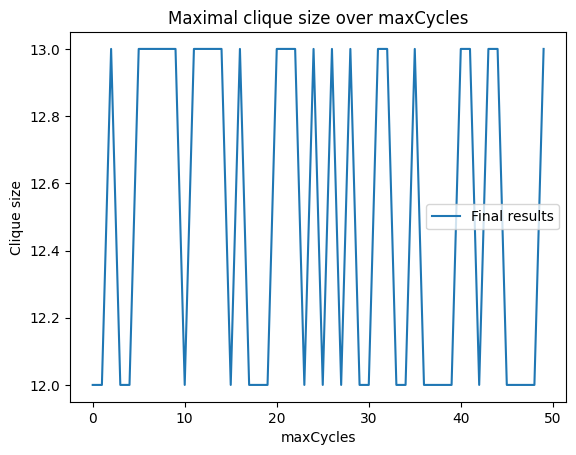

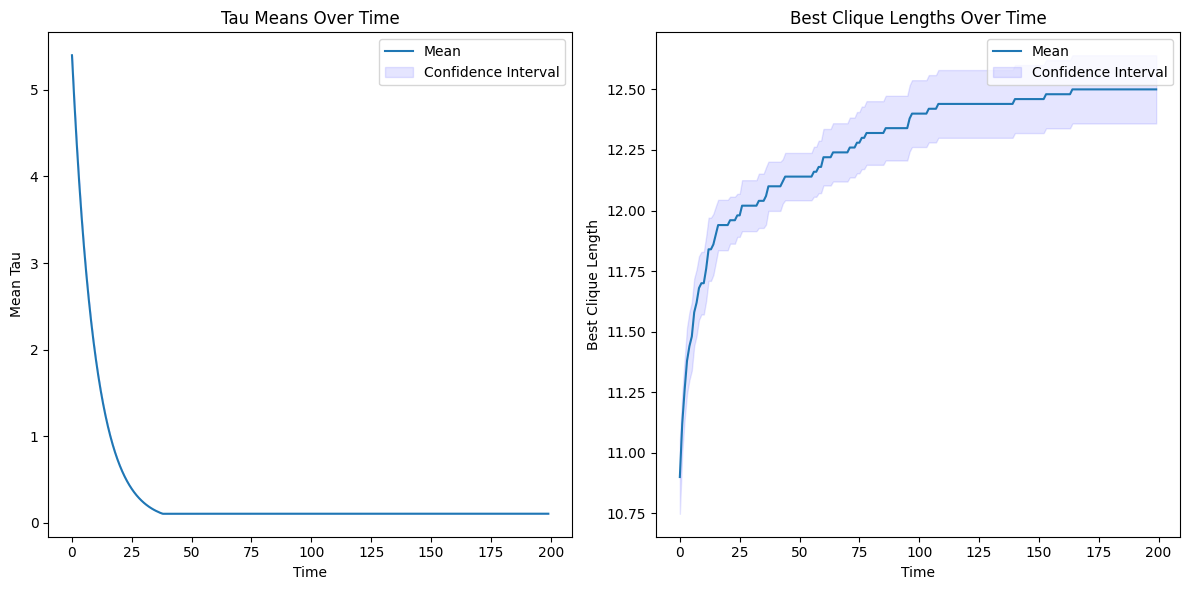

In [ ]:
def plot_results(final_results, tau_means_runs, best_clique_lengths_runs):
    plt.plot(final_results, label='Final results')
    plt.title("Maximal clique size over maxCycles")
    plt.xlabel("maxCycles")
    plt.ylabel("Clique size")
    plt.legend()
    plt.show()
    # Compute the mean and standard error of the mean for tau_means_runs
    tau_means_mean = np.mean(tau_means_runs, axis=0)
    tau_means_sem = sem(tau_means_runs, axis=0)

    # Compute the confidence intervals
    confidence_interval_tau_means = t.interval(0.95, len(tau_means_mean)-1, loc=tau_means_mean, scale=tau_means_sem)

    # Compute the mean and standard error of the mean for best_clique_lengths_runs
    best_clique_lengths_mean = np.mean(best_clique_lengths_runs, axis=0)
    best_clique_lengths_sem = sem(best_clique_lengths_runs, axis=0)

    # Compute the confidence intervals
    confidence_interval_best_clique_lengths = t.interval(0.95, len(best_clique_lengths_mean)-1, loc=best_clique_lengths_mean, scale=best_clique_lengths_sem)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(tau_means_mean, label="Mean")
    plt.fill_between(range(len(tau_means_mean)), confidence_interval_tau_means[0], confidence_interval_tau_means[1], color='b', alpha=.1, label="Confidence Interval")
    plt.title("Tau Means Over Time")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Tau")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(best_clique_lengths_mean, label="Mean")
    plt.fill_between(range(len(best_clique_lengths_mean)), confidence_interval_best_clique_lengths[0], confidence_interval_best_clique_lengths[1], color='b', alpha=.1, label="Confidence Interval")
    plt.title("Best Clique Lengths Over Time")
    plt.xlabel("Iterations")
    plt.ylabel("Best Clique Length")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(final_results, tau_means_runs, best_clique_lengths_runs)


In [ ]:
#draw_graph(G, bestClique)